In [1]:
import sys
import os
import numpy as np
import pandas as pd

from Dissects.io import (load_NDskl, 
                         load_image,
                         load_skeleton,
                         save_skeleton,
                         save_fits
                        )

from Dissects.image import (z_project,
                            thinning,
                            dilation)
from Dissects.geometry import Skeleton
from Dissects.segmentation.seg_2D import (segmentation, 
                                          junction_around_cell,
                                         vertices,
                                         junctions,
                                         generate_mesh)
from Dissects.analysis.analysis import (general_analysis,
                              cellstats
                              )

%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt

### Load image and take some information

In [2]:
# load image
image, metadata = load_image("/home/admin-suz/Documents/Code/Dissects/Dissects/stores/2d_images.tif")

In [3]:
pixel_ratio = metadata['pixel_ratio']
print(metadata)

{'pixel_ratio': 0.18323109343704702, 'height': 337, 'width': 576}


### Load file from Disperse and generate a skeleton

In [4]:
# #load ndskl file 
# cp, fil, point, specs = load_NDskl("/home/admin-suz/Documents/Code/Dissects/Dissects/stores/2d_images.NDskl.a.NDskl")
# #create skeleton object
# skel = Skeleton(cp, fil, point, specs)

In [5]:
# Load skeleton to go faster
# Load skeleton
data = load_skeleton('/home/admin-suz/Documents/Code/Dissects/Dissects/stores/2d_skeleton.hf5')
skel = Skeleton(data['critical_point'], data['filament'], data['point'])

# Load specs information if you load skeleton from hf5 file
specs = {'ndims': 2,
 'bbox': np.array([0., 0.]),
 'bbox_delta': np.array([576., 337.]),
 'ncrit': 3525,
 'nfil': 3522}
skel.specs = specs

/home/admin-suz/miniconda3/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:25: UserWarning: Has pixel can be half pixel from DisPerSE output,                   we take the integer part of xyz values. 
  we take the integer part of xyz values. ")


In [6]:
#Clean skeleton
skel.remove_lonely_cp()
skel.remove_free_filament()

/home/admin-suz/miniconda3/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:61: UserWarning: specs dictionnary is not updated, ncrit value is not updated.
  "specs dictionnary is not updated, ncrit value is not updated.")


<IPython.core.display.Javascript object>


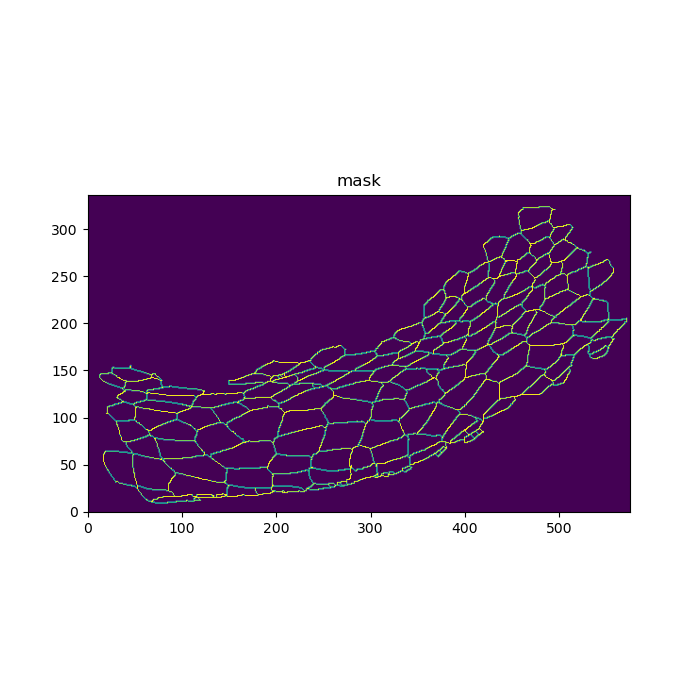

In [7]:
# Create mask and plot
mask = skel.create_binary_image()

plt.figure(figsize=(7,7))
plt.imshow(mask, origin='lower')
plt.title('mask')
mask = mask.astype(int)

### Segmentation

It is possible when process the segmentation to not take into account cell which have an area bellow `min_area`.

In [8]:
min_area = 10
seg = segmentation(mask, min_area)

## Analysis 

Since the skeleton is composed of filament of one pixel large. The skeleton need to be enlarge to measure correctly the junction. 

The enlargement value depend of your type of image, signal... 

In [9]:
width = 1
df_result = cellstats(image, 
                        mask, 
                        width,
                        seg,
                        'alpha-cat', 
                        1/pixel_ratio)

/home/admin-suz/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/admin-suz/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/admin-suz/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/admin-suz/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/admin-suz/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
df_result

,CellNbr,perimeter_um,areaCell_um2,meanCell_alpha-cat,stdCell_alpha-cat,semCell_alpha-cat,meanJunc_alpha-cat,stdJunc_alpha-cat,semJunc_alpha-cat
0,2.0,16.857261,6.714727,2325.550000,1758.058278,176.691505,7165.116129,4402.412673,250.444507
1,3.0,15.208181,9.400617,1260.055866,987.009273,73.979473,4935.668874,3419.218266,197.080464
2,5.0,6.413088,1.040783,NaN,NaN,NaN,6664.771930,4149.585752,390.360191
3,6.0,27.667895,33.707928,1378.391990,1232.943285,42.977701,6103.937381,4188.436616,182.624515
4,7.0,3.481391,0.436457,NaN,NaN,NaN,6092.621212,2816.138065,349.298937
...,...,...,...,...,...,...,...,...,...
145,159.0,15.208181,18.633367,1059.083710,326.265188,15.536438,6273.822086,4406.117504,244.407424
146,160.0,12.093252,11.347888,1239.024490,743.871658,47.621503,7830.208955,4412.621545,270.048053
147,161.0,11.177097,8.561277,1220.341040,459.630292,35.046481,7393.537190,3866.206012,249.044222
148,162.0,14.658487,14.235221,1105.221519,575.278855,32.413291,6351.563694,3839.969293,217.047897
